## Adaptive RAG

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

Retriever

In [2]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name = "sentence-transformers/all-MiniLM-L6-v2"
)

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

## Load 
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

## SPlit
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000, chunk_overlap = 100
)
docs_split = text_splitter.split_documents(docs_list)

## Add to vector store 
vectorStore = FAISS.from_documents(
    documents=docs_split,
    embedding= embeddings
)

retriever = vectorStore.as_retriever()

d:\RAGs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


Router

In [3]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from pydantic import BaseModel, Field

## Data Model
class RouteQuery(BaseModel):
    """Route a query to the most relevent data source."""

    dataSource: Literal["vectorStore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorStore."
    )

llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

## Prompt 
system = """
    You are an expert at routing a user question to a vector store or web search.
    The vector Store contains documents related to agent, prompt engineering, and adversarial attacks.
    Use the vectorStore for question on these topics. Otherwise use webSearch.
"""

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = router_prompt | structured_llm_router

In [4]:
print(
    question_router.invoke(
        {"question":"What is K-Shot Prompting?"}
    )
)

dataSource='vectorStore'


Retrieval Grader

In [5]:
## Data Model
class GradeDocuments(BaseModel):
    """Binary score for the relevance check on the retrieved documents"""

    binary_score: str = Field(
        description="Documents are relevant to the question 'yes' or 'no'"
    )

## LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

## Prompt 
system = """You are a grader assessing relevance of the retrieved documents to a user question
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
    If does not need to be a stringent test. The goal is to filter out erroneous retrievals.
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved Documents: \n\n {documents} \n\n User Question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "Agent Memory"
docs = retriever.invoke(question)
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question":question, "documents":doc_txt}))

binary_score='yes'


Generate

In [6]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

##prompt 
prompt = PromptTemplate(
        input_variables=["context", "question"],
        template=(
            "You are an assistant for question-answering tasks.\n"
            "Use the provided context to answer the question.\n"
            "Do NOT reveal your reasoning or chain-of-thought.\n"
            "Only provide the final concise answer.\n\n"
            "Context:\n{context}\n\n"
            "Question:\n{question}\n\n"
            "Answer:"
        )
    )

llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## Chain 
rag_chain = prompt | llm | StrOutputParser()

## Run
generation = rag_chain.invoke({
    "context":docs,
    "question":question
})
print(generation)

<think>
</think>

In a LLM-powered autonomous agent system, memory is divided into two types: short-term and long-term. Short-term memory involves in-context learning, akin to prompt engineering, where the model learns from immediate context. Long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. Additionally, memory systems may include a memory stream to record experiences, a retrieval model to surface relevant context, and a reflection mechanism to synthesize memories into higher-level inferences for guiding future behavior.


Hallucination Grader

In [7]:
## Data Model
class GradeHallucinations(BaseModel):
    """Binary Score for hallucination present in the generaation answer"""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no' "
    )

## LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)
structured_llm_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
"""

hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_hallucination_grader
hallucination_grader.invoke({"documents":docs, "generation": generation})

GradeHallucinations(binary_score='yes')

Answer Grader

In [8]:
## Data Model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )

## LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)
structured_llm_answer_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_answer_grader
answer_grader.invoke({"question": question, "generation":generation})

GradeAnswer(binary_score='yes')

Question re writer

In [9]:
llm = ChatGroq(model="qwen/qwen3-32b", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
    for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Do NOT reveal your reasoning or chain-of-thought.\n
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'<think>\nOkay, the user provided the initial question "Agent Memory" and wants an improved version for vectorstore retrieval. Let me think about what they might be looking for.\n\nFirst, "Agent Memory" is pretty vague. Vectorstores work best with specific, detailed queries. Maybe they want to know how agent memory is implemented in AI systems. Or perhaps they\'re asking about the mechanisms or best practices for managing memory in AI agents.\n\nI should consider different angles. Are they looking for technical details, like data structures or algorithms? Or maybe they want to understand the purpose and benefits of agent memory in AI applications. The term "formulate an improved question" suggests they need a more precise query.\n\nPossible rephrases could be: "What are the key components of agent memory in AI systems?" or "How is memory managed in AI agents for efficient data retrieval?" Another angle might be about challenges or optimization techniques. Maybe "What are the best pract

Web Search

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tools = TavilySearchResults(k = 3)

C:\Users\rajpu\AppData\Local\Temp\ipykernel_15048\1170902126.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tools = TavilySearchResults(k = 3)


In [12]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our Graph

    Attr:
        question: question
        generation: LLM generation
        documents: list of docs
    """

    question: str
    generation: str
    documents: List[str]

In [13]:
from langchain_core.documents import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("--RETRIEVE--")
    question = state["question"]

    ## retrieval
    documents = retriever.invoke(question)
    return {"documents":documents, "question":question}

In [25]:
def generate(state):
    """
    Generate Answer

    Args:
        state (dict): The current graph state
    
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("--GENERATION--")
    question = state["question"]
    documents = state["documents"]

    ## RAG generation
    generation = rag_chain.invoke({"context":documents, "question":question})
    return {"context":documents, "question":question, "generation":generation}

In [68]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    question = state["question"]
    documents = state["documents"]

    filtered_docs = []

    for d in documents:
        result = retrieval_grader.invoke({
            "question": question,
            "documents": d.page_content
        })

        grade = result.binary_score.lower().strip()

        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")

    return {
        "documents": filtered_docs,
        "question": question
    }


In [69]:
def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("--TRANSFORM QUERY--")
    question = state["question"]
    documents = state["documents"]

    ## Re-Write Question
    better_question = question_rewriter.invoke({"question":question})
    return {"documents":documents, "question":better_question}

In [70]:
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("--WEB SEARCH--")
    question = state["question"]

    ## Web Search
    docs = web_search_tools.invoke({"query":question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question":question}

## EDGES ##

In [71]:
def route_question(state):
    """
    "vectorStore", "web_search"

    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("--ROUTE QUESTION--")
    question = state["question"]
    source = question_router.invoke({"question":question})

    if source.dataSource == "web_search":
        print("--ROUTE QUESTION TO WEB SEARCH--")
        return "web_search"
    elif source.dataSource == "vectorStore":
        print("--ROUTE QUESTION TO RAG--")
        return "vectorStore"

In [ ]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("--ASSESS GRADED DOCS--")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print("---DECISION: ALL DOCS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        return "transform_query"
    else:
        print("--DECISION: RELEVANT DOCS--")
        return "generate"

In [73]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [79]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

# Nodes
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)

# Routing from START
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorStore": "retrieve"
    }
)

# Web search path
workflow.add_edge("web_search", "generate")

# Vector store path
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    }
)

workflow.add_edge("transform_query", "retrieve")

# 🔥 CORRECT placement of generation grading
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "not useful": "transform_query",
        "useful": END
    }
)

app = workflow.compile()


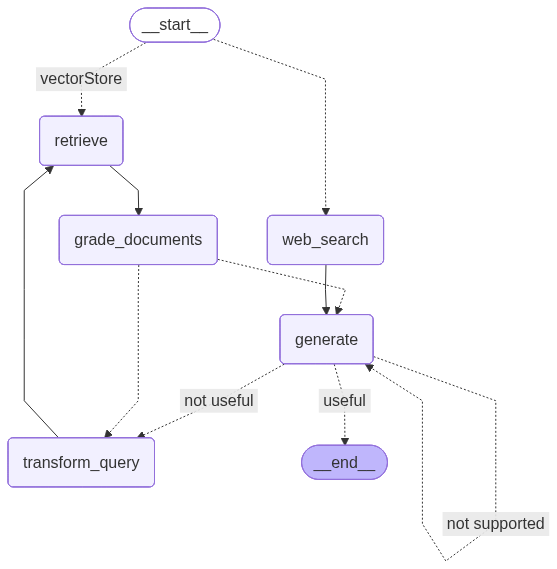

In [80]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [81]:
app.invoke({"question":"WHat is agent Memory?"})

--ROUTE QUESTION--
--ROUTE QUESTION TO RAG--
--RETRIEVE--
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
--ASSESS GRADED DOCS--
--DECISION: RELEVANT DOCS--
--GENERATION--
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'WHat is agent Memory?',
 'generation': "<think>\n\n</think>\n\nAgent Memory in an LLM-powered autonomous agent system refers to the components that enable the agent to retain, recall, and utilize information over time. It includes:\n\n1. **Short-term memory**: Utilized through in-context learning, allowing the agent to learn from immediate interactions or prompts.\n2. **Long-term memory**: Stores extensive information over extended periods, often using an external vector store for fast retrieval. This includes:\n   - **Memory stream**: A record of the agent's experiences in natural language.\n   - **Retrieval model**: Surfaces relevant context based on recency, importance, and relevance.\n   - **Reflection mechanism**: Synthesizes memories into higher-level inferences to guide future behavior.",
 'documents': [Document(id='850267bf-46e3-4d33-984e-92a842547d1f', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Age

In [82]:
app.invoke({"question":"WHat is A bitcoin?"})

--ROUTE QUESTION--
--ROUTE QUESTION TO WEB SEARCH--
--WEB SEARCH--
--GENERATION--
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'WHat is A bitcoin?',
 'generation': '<think>\n\n</think>\n\nA bitcoin is a digital currency that operates on a decentralized peer-to-peer network, enabling direct transactions between users without the need for a central authority. It is secured through cryptographic technology and recorded on a public ledger called the blockchain. Bitcoin has no physical form and exists purely in digital form, with a capped supply of 21 million coins.',
 'documents': Document(metadata={}, page_content='Learn more: How to start investing: A 6-step guide\n\n## What exactly is bitcoin, and how does it work?\n\nBitcoin is a type of cryptocurrency, which is a currency that exists only in digital form and operates without government or banking oversight. By comparison, the U.S. dollar, the EU euro, the Canadian dollar, and other national currencies have paper versions and are issued by their respective governments.\n\nBitcoin relies on a public digital ledger that validates and records transac